In [1]:
# pip install timm==0.6.12

In [2]:
!cd ../

In [3]:
!pwd

/content/Men-in-Black/Monocular Depth Estimation/ZoeDepth/notebooks


In [4]:
# pip install ultralytics

In [2]:
import sys
sys.path.append('../')  # 상위 디렉토리 추가

In [3]:
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
from ultralytics import YOLO
from zoedepth.utils.misc import colorize
import torch.nn as nn
%matplotlib inline


In [4]:
# Load YOLO model for vehicle detection
coco_model = YOLO('yolov8m.pt')
vehicles = [1, 2, 3, 5, 7]  # Coco dataset class nums for vehicles
traffic_light = [9]

In [5]:
torch.hub.help("intel-isl/MiDaS", "DPT_BEiT_L_384", force_reload=True)  # Triggers fresh download of MiDaS repo

Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /home/ubuntu/.cache/torch/hub/master.zip


' # This docstring shows up in hub.help()\n    MiDaS DPT_BEiT_L_384 model for monocular depth estimation\n    pretrained (bool): load pretrained weights into model\n    '

In [6]:
repo = "isl-org/ZoeDepth"
# Zoe_N
model_zoe_n = torch.hub.load(repo, "ZoeD_N", pretrained=True)

# Zoe_K
model_zoe_k = torch.hub.load(repo, "ZoeD_K", pretrained=True)

# Zoe_NK
model_zoe_nk = torch.hub.load(repo, "ZoeD_NK", pretrained=True)

Using cache found in /home/ubuntu/.cache/torch/hub/isl-org_ZoeDepth_main


img_size [384, 512]


Using cache found in /home/ubuntu/.cache/torch/hub/intel-isl_MiDaS_master
/home/ubuntu/anaconda3/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Loaded successfully


Using cache found in /home/ubuntu/.cache/torch/hub/isl-org_ZoeDepth_main


Overwriting config with config_version kitti
img_size [384, 768]


Using cache found in /home/ubuntu/.cache/torch/hub/intel-isl_MiDaS_master


Params passed to Resize transform:
	width:  768
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_K.pt
Loaded successfully


Using cache found in /home/ubuntu/.cache/torch/hub/isl-org_ZoeDepth_main
Using cache found in /home/ubuntu/.cache/torch/hub/intel-isl_MiDaS_master


img_size [384, 512]
Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_NK.pt
Loaded successfully


In [7]:
# # Load depth estimation model
# repo = "isl-org/ZoeDepth"
# model_zoe_nk = torch.hub.load(repo, "ZoeD_NK", pretrained=False)
# pretrained_dict = torch.hub.load_state_dict_from_url('https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_NK.pt', map_location='cpu')
# model_zoe_nk.load_state_dict(pretrained_dict['model'], strict=False)
# for b in model_zoe_nk.core.core.pretrained.model.blocks:
#     b.drop_path = nn.Identity()


In [8]:
zoe = model_zoe_nk.to('cuda')

/home/ubuntu/anaconda3/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [9]:
# Function to convert OpenCV image to PIL image
def cv2_to_pil(cv2_image):
    cv2_image_rgb = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(cv2_image_rgb)
    return pil_image

# Function to get depth estimation
# def get_depth_estimation(frame):
#     frame_tensor = torch.nn.functional.interpolate(
#         torch.unsqueeze(torch.from_numpy(np.array(frame)).permute(2, 0, 1), 0).float(),
#         (192, 640),
#         mode="bilinear",
#         align_corners=False
#     )
#     with torch.no_grad():
#         depth = model_zoe_nk(frame_tensor)[0].cpu().numpy()
#     depth_resized = cv2.resize(depth, frame.size[::-1], interpolation=cv2.INTER_LINEAR)
#     colored_depth = colorize(depth_resized)
#     return colored_depth

# def get_depth_estimation(frame):
#     depth = zoe.infer_pil(frame, pad_input=False)
    
#     # Convert size to int if necessary
#     depth_size = depth.shape[:2]
#     depth_size = (int(depth_size[0]), int(depth_size[1]))

#     colored_depth = colorize(depth)
#     return colored_depth

def get_depth_estimation(frame):
    # Get raw depth data (in meters)
    raw_depth = zoe.infer_pil(frame, pad_input=False, output_type="numpy")

    # Colorize for visualization
    colored_depth = colorize(raw_depth)
    return raw_depth, colored_depth


In [10]:
# Load video
video_path = '/content/Men-in-Black/sample_videos/test_input_video(5sec)(1920x1080_30FPS).mp4'
cap = cv2.VideoCapture(video_path)

In [11]:
cap.isOpened()

True

In [12]:
# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break

#     # Detect objects in the frame
#     detections = coco_model(frame)[0]
#     frame_with_detections = frame.copy()
#     depth_image = get_depth_estimation(cv2_to_pil(frame))
#     depth_image_with_detections = depth_image.copy()

#     # Process each detection
#     for detection in detections.boxes.data.tolist():
#         x1, y1, x2, y2, score, class_id = detection
#         if int(class_id) in vehicles or int(class_id) in traffic_light:
#             # Draw bounding boxes on both the original and depth images
#             for target_frame in [frame_with_detections, depth_image_with_detections]:
#                 cv2.rectangle(target_frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

#     # Convert frames for displaying
#     frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     frame_with_detections_rgb = cv2.cvtColor(frame_with_detections, cv2.COLOR_BGR2RGB)

#     # Display the images using Matplotlib
#     plt.figure(figsize=(18, 6))
#     for i, (img, title) in enumerate(zip([frame_rgb, frame_with_detections_rgb, depth_image_with_detections], 
#                                          ["Original Frame", "Frame with Detections", "Depth Map with Detections"])):
#         plt.subplot(1, 3, i+1)
#         plt.imshow(img)
#         plt.title(title)
#         plt.axis('off')
#     plt.show()

#     # Break the loop if 'q' is pressed
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()


0: 384x640 1 person, 13 cars, 2 buss, 1 truck, 2 traffic lights, 27.1ms
Speed: 2.3ms preprocess, 27.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


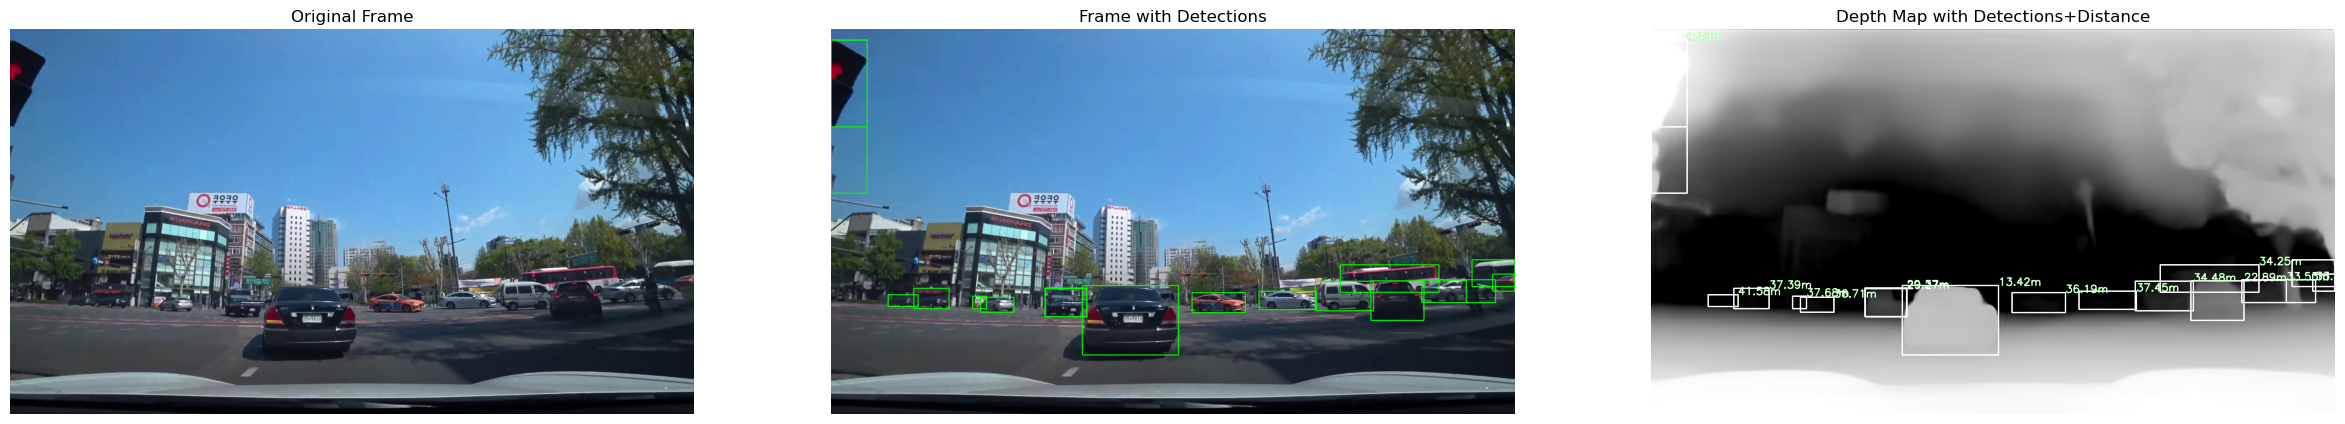


0: 384x640 1 person, 12 cars, 2 buss, 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


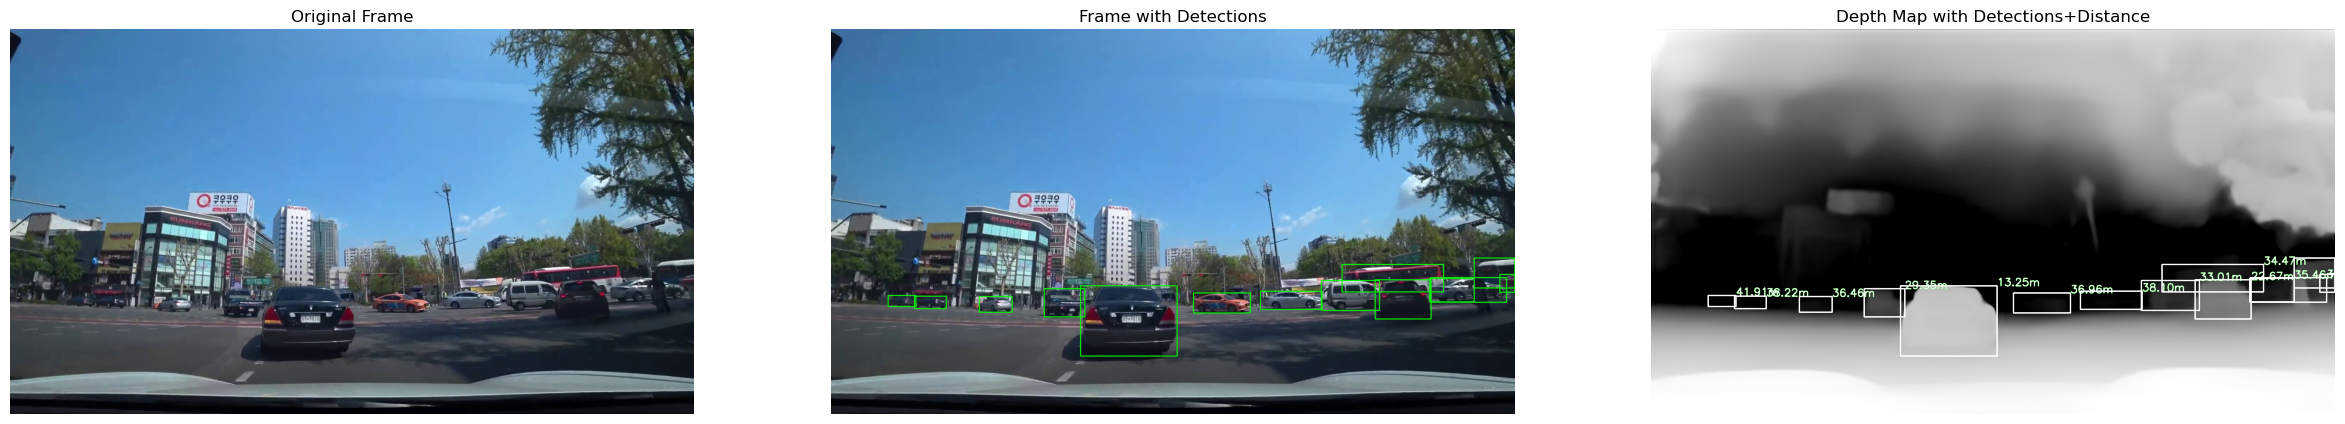


0: 384x640 1 person, 12 cars, 1 bus, 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


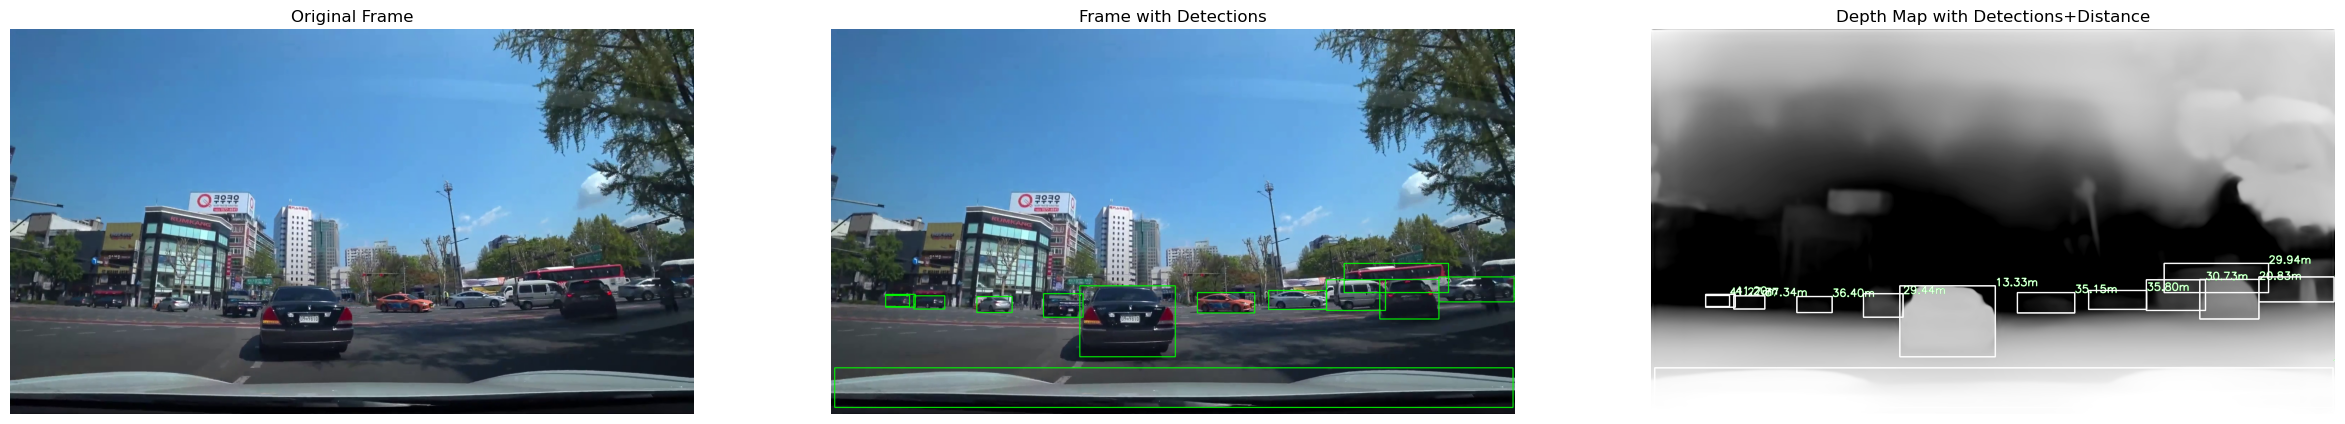


0: 384x640 1 person, 11 cars, 4 buss, 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


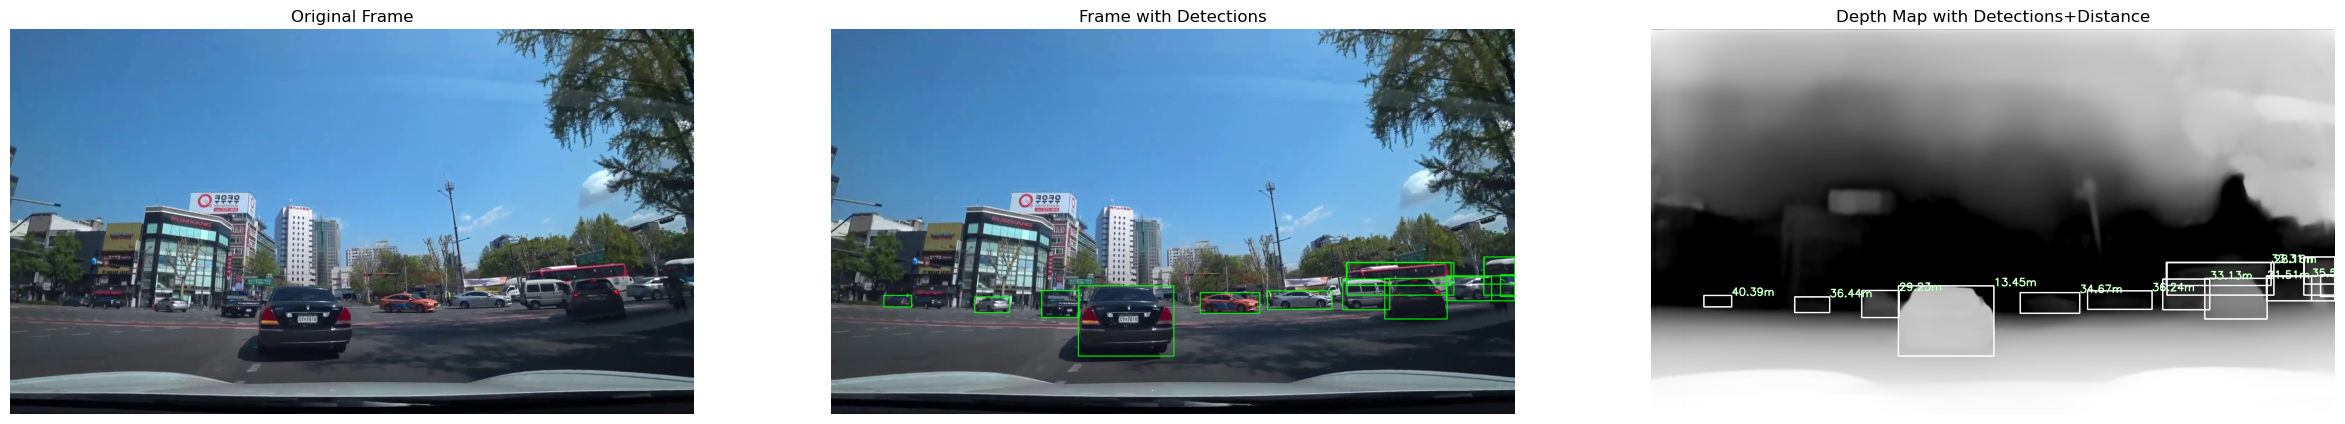


0: 384x640 12 cars, 2 buss, 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


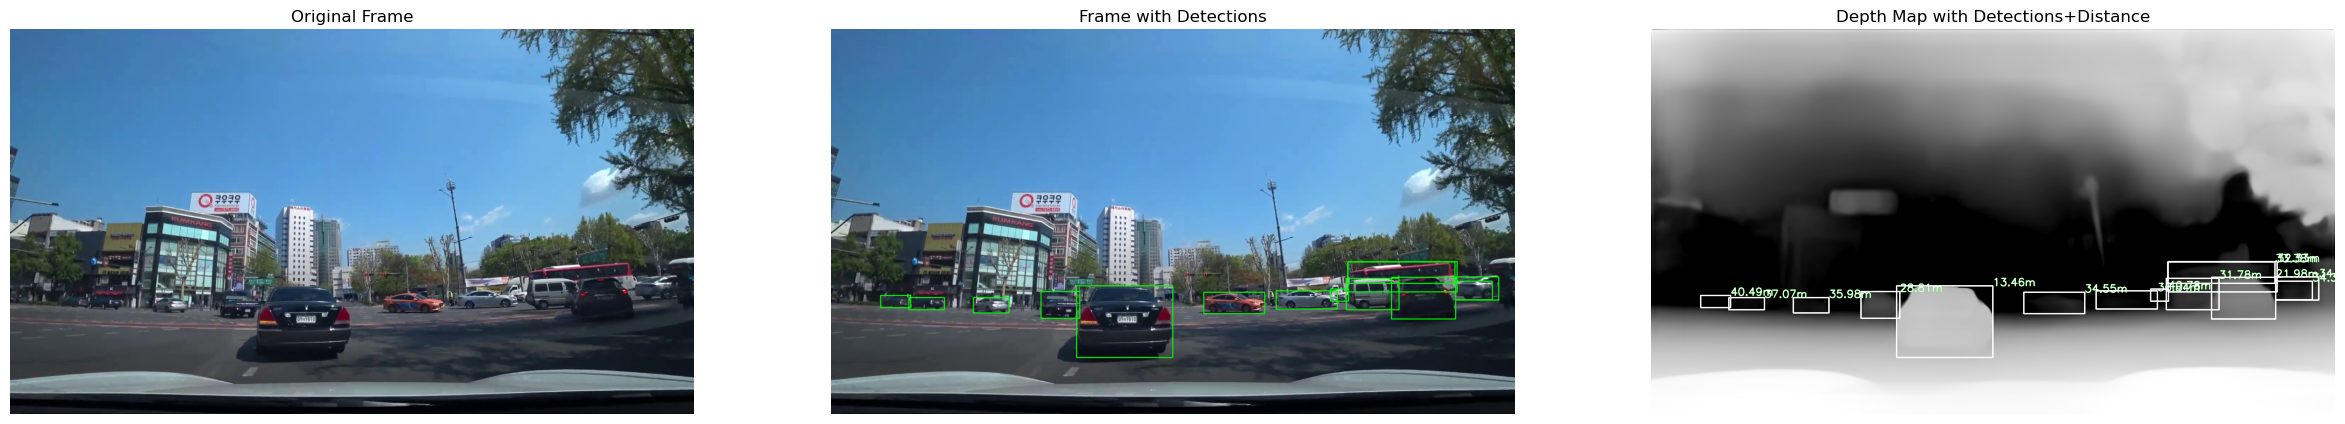


0: 384x640 14 cars, 3 buss, 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


KeyboardInterrupt: 

In [15]:
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # # Detect objects in the frame
    # detections = coco_model(frame)[0]
    # frame_with_detections = frame.copy()
    # depth_image = get_depth_estimation(cv2_to_pil(frame))

    # Detect objects in the frame
    detections = coco_model(frame)[0]
    frame_with_detections = frame.copy()
    raw_depth, depth_image = get_depth_estimation(cv2_to_pil(frame))
    depth_image_with_detections = depth_image.copy()



    # Process each detection
    for detection in detections.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = detection
        if int(class_id) in vehicles or int(class_id) in traffic_light:
            # Calculate center of the bounding box (you can use this if needed)
            center_x = int((x1 + x2) / 2)
            center_y = int((y1 + y2) / 2)
    
            # Get depth value at the center from raw depth data
            depth_value = raw_depth[center_y, center_x]
    
            # Ensure depth_value is a single float value
            if isinstance(depth_value, np.ndarray):
                depth_value = np.mean(depth_value)
    
            # Draw bounding boxes on both images
            cv2.rectangle(frame_with_detections, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            cv2.rectangle(depth_image_with_detections, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
    
            # Text position (top right corner of the bounding box)
            text_position = (int(x2), int(y1))
    
            # Increase font size
            font_scale = 1
    
            # Write depth value on the depth image
            cv2.putText(depth_image_with_detections, f"{depth_value:.2f}m", text_position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), 2)

    # Convert frames for displaying
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_with_detections_rgb = cv2.cvtColor(frame_with_detections, cv2.COLOR_BGR2RGB)

    # Display the images using Matplotlib
    plt.figure(figsize=(30, 15))
    for i, (img, title) in enumerate(zip([frame_rgb, frame_with_detections_rgb, depth_image_with_detections], 
                                         ["Original Frame", "Frame with Detections", "Depth Map with Detections+Distance"])):
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()